## Lab Work 7: Ensemble Methods

This notebook builds on the same lecture of Foundations of Machine Learning. We'll focus on Ensemble Methods.

Important note: the steps shown here are not always the most efficient or the most "industry-approved." Their main purpose is pedagogical. So don't panic if something looks suboptimal—it's meant to be.

If you have questions (theoretical or practical), don't hesitate to bug your lecturer.


First the necessary imports:

In [7]:
# Basic libraries for data handling and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn tools for preprocessing and modeling
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Baseline model
from sklearn.linear_model import LogisticRegression

# Ensemble models
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
# Metrics
from sklearn.metrics import balanced_accuracy_score, accuracy_score,classification_report, roc_auc_score





### Step 0
Decision tree for regression: visualization. Generate synthetic data using a noisy Sin function and try to fit it with a decision tree regressor. 

The criterion is reduce the variance 
$\text{Var}_{\text{split}} = \frac{|S_L|}{|S|}\text{Var}(S_L) + \frac{|S_R|}{|S|}\text{Var}(S_R)$

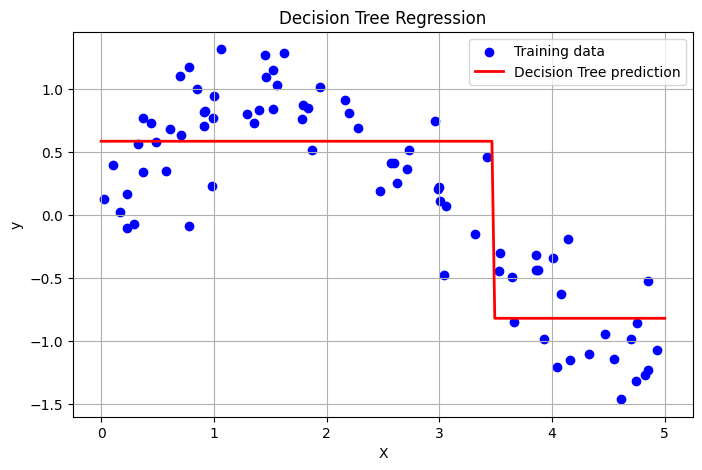

In [2]:
import numpy as np
import matplotlib.pyplot as plt


# ----- Generate synthetic data -----
np.random.seed(42)
X = np.sort(5 * np.random.rand(80, 1), axis=0)  # 80 samples in [0,5]
y = np.sin(X).ravel() + 0.3 * np.random.randn(80)  # sin function + noise

# ----- Fit Decision Tree Regressor -----
tree_reg = DecisionTreeRegressor(max_depth=1, random_state=42)
tree_reg.fit(X, y)

# ----- Predict -----
X_test = np.linspace(0, 5, 200).reshape(-1, 1)
y_pred = tree_reg.predict(X_test)

# ----- Plot -----
plt.figure(figsize=(8,5))
plt.scatter(X, y, c='blue', label='Training data')
plt.plot(X_test, y_pred, color='red', linewidth=2, label='Decision Tree prediction')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Decision Tree Regression')
plt.legend()
plt.grid(True)
plt.show()

### MAGIC Gamma Telescope Dataset (UCI)

This dataset comes from the MAGIC (Major Atmospheric Gamma Imaging Cherenkov) Telescope, used to study high-energy gamma rays. The objective is to classify whether each recorded event is: g → a gamma-ray event (signal), h → a hadronic shower (background noise).

Import the dataset from the UCI Machine Learning repository using `fetch_ucirepo` with id=159 and split features from target.

In [2]:
from ucimlrepo import fetch_ucirepo
import pandas as pd

# Fetch Mushroom dataset
magic_gamma_telescope = fetch_ucirepo(id=159) 
X = magic_gamma_telescope.data.features
y = magic_gamma_telescope.data.targets

# Convert y to Series if it's a DataFrame
if isinstance(y, pd.DataFrame):
    y = y.iloc[:, 0]  # take the first (and only) column

# Inspect dataset
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)
display(X.head())
print("Target distribution:")
print(y.value_counts())



Shape of X: (19020, 10)
Shape of y: (19020,)


,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620


Target distribution:
class
g    12332
h     6688
Name: count, dtype: int64


### Step 1
Build a preprocessing + Logistic Regression pipeline that will be the benchmark.
Since all features are numerical, just pass them through with a ColumnTransformer, then add a LogisticRegression classifier to the pipeline. Fill in the code below to complete the baseline model setup.


In [3]:
# Identify numerical features (in this case all features are numerical)
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
print("Numerical features:", numerical_features)

# Since there are no categorical features, no preprocessing transformer is needed
# We simply pass numerical features through directly
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features)
    ]
)


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


# Baseline pipeline: preprocessing + Logistic Regression
baseline_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=10000))
])


Numerical features: ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist']


### Step 2

The fundamental "trinity": fit your pipeline on the training set, generate predictions on the test set, and report performance metrics such as accuracy and the classification report.

In [4]:

# Fit model
baseline_pipeline.fit(X_train, y_train)

# Predictions
y_pred = baseline_pipeline.predict(X_test)

# Evaluation
print("Baseline Logistic Regression performance:")
print("Accuracy:", balanced_accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Baseline Logistic Regression performance:
Accuracy: 0.7512108269785239
              precision    recall  f1-score   support

           g       0.81      0.90      0.85      3700
           h       0.77      0.60      0.67      2006

    accuracy                           0.80      5706
   macro avg       0.79      0.75      0.76      5706
weighted avg       0.79      0.80      0.79      5706



### Step 3

Using `DecisionTreeClassifier` as introduced during the theoretical lecture, plot the performances on test and training in function of the depth as you did for the IRIS dataset

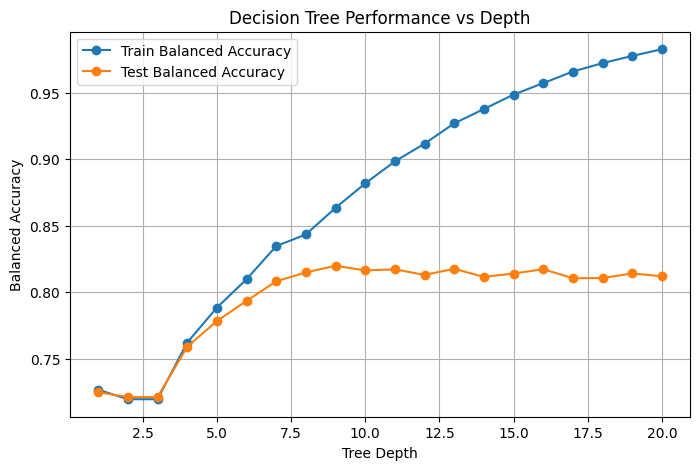

In [5]:


# Test different tree depths
max_depths = list(range(1, 21))  # depths from 1 to 20
train_scores = []
test_scores = []

for depth in max_depths:
    dt = DecisionTreeClassifier(max_depth=depth, random_state=42)
    dt.fit(X_train, y_train)
    
    # Balanced accuracy
    train_scores.append(balanced_accuracy_score(y_train, dt.predict(X_train)))
    test_scores.append(balanced_accuracy_score(y_test, dt.predict(X_test)))

# Plot results
plt.figure(figsize=(8,5))
plt.plot(max_depths, train_scores, label='Train Balanced Accuracy', marker='o')
plt.plot(max_depths, test_scores, label='Test Balanced Accuracy', marker='o')
plt.xlabel('Tree Depth')
plt.ylabel('Balanced Accuracy')
plt.title('Decision Tree Performance vs Depth')
plt.legend()
plt.grid(True)
plt.show()

### Step 4: Bagging

Compare Bagging and Random Forests using decision trees as base learners. Both are ensemble methods, but they differ in how diversity is introduced among the trees:

1. Bagging (Bootstrap Aggregating)
	-	Each tree is trained on a different bootstrap sample of the training data.
	-	All features are considered when splitting nodes.
	-	Final prediction is obtained by averaging (regression) or majority vote (classification).
	-	Reduces variance compared to a single decision tree, but may still overfit if trees are deep.
	
Note: Bagging can be used with other base classifiers!

2. Random Forest. Builds on bagging, but adds feature randomness:
	-	At each split, only a random subset of features is considered.
	-	This additional randomness further decorrelates trees, usually improving generalization.

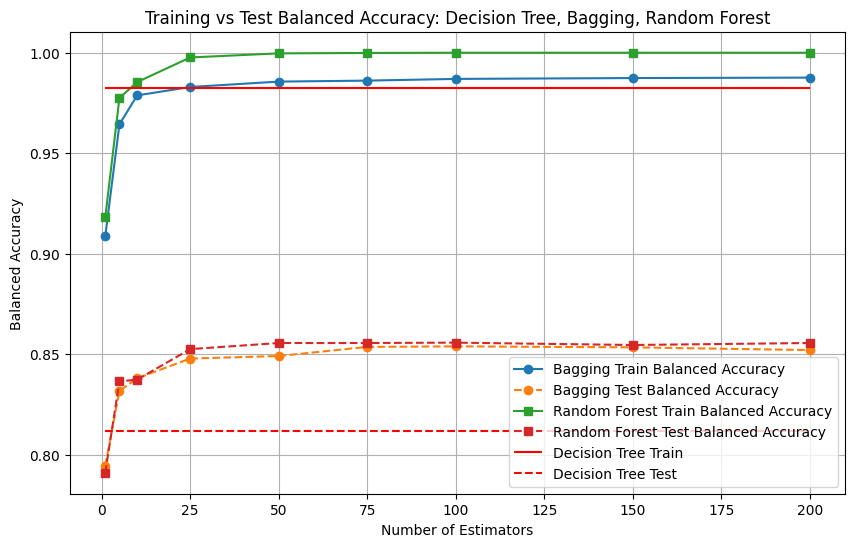

In [6]:
# ----- Parameters -----
n_estimators_list = [1, 5, 10, 25, 50, 75, 100, 150, 200]

# Storage
bagging_bal_train = []
bagging_bal_test = []
rf_bal_train = []
rf_bal_test = []

# Loop over different numbers of estimators
for n in n_estimators_list:
    # ----- Bagging -----
    bagging_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', BaggingClassifier(
            estimator=DecisionTreeClassifier(max_depth=20),
            n_estimators=n,
            random_state=42
        ))
    ])
    bagging_pipeline.fit(X_train, y_train)
    # Balanced accuracy
    bagging_bal_train.append(balanced_accuracy_score(y_train, bagging_pipeline.predict(X_train)))
    bagging_bal_test.append(balanced_accuracy_score(y_test, bagging_pipeline.predict(X_test)))
    
    # ----- Random Forest -----
    rf_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(
            n_estimators=n,
            max_depth=None,
            random_state=42,
            n_jobs=-1
        ))
    ])
    rf_pipeline.fit(X_train, y_train)
    rf_bal_train.append(balanced_accuracy_score(y_train, rf_pipeline.predict(X_train)))
    rf_bal_test.append(balanced_accuracy_score(y_test, rf_pipeline.predict(X_test)))

# ----- Single Decision Tree for reference -----
dt = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(max_depth=20, random_state=42))
])
dt.fit(X_train, y_train)
dt_bal_train = balanced_accuracy_score(y_train, dt.predict(X_train))
dt_bal_test = balanced_accuracy_score(y_test, dt.predict(X_test))

# ----- Plot -----
plt.figure(figsize=(10,6))
plt.plot(n_estimators_list, bagging_bal_train, 'o-', label='Bagging Train Balanced Accuracy')
plt.plot(n_estimators_list, bagging_bal_test, 'o--', label='Bagging Test Balanced Accuracy')
plt.plot(n_estimators_list, rf_bal_train, 's-', label='Random Forest Train Balanced Accuracy')
plt.plot(n_estimators_list, rf_bal_test, 's--', label='Random Forest Test Balanced Accuracy')
plt.hlines(dt_bal_train, n_estimators_list[0], n_estimators_list[-1], colors='red', linestyles='-', label='Decision Tree Train')
plt.hlines(dt_bal_test, n_estimators_list[0], n_estimators_list[-1], colors='red', linestyles='--', label='Decision Tree Test')
plt.xlabel('Number of Estimators')
plt.ylabel('Balanced Accuracy')
plt.title('Training vs Test Balanced Accuracy: Decision Tree, Bagging, Random Forest')
plt.legend()
plt.grid(True)
plt.show()

### Step 5: Boosting

Compare boosting methods using shallow decision trees as base learners. Boosting builds an ensemble sequentially, where each model focuses on improving the errors of the previous ones.

1. AdaBoost
	-	Sequentially fits weak learners, giving more weight to misclassified samples.
	-	Reduces bias of weak learners, but can be sensitive to noise.
	-   Final prediction: Each weak learner votes, weighted by its accuracy. The class with the highest total vote is predicted.

2. Gradient Boosting
	-	Sequentially fits models to residual errors of previous models using gradient descent.
	-	More flexible than AdaBoost: supports regression, classification, and custom loss functions.
	-   t each step j, we compute the pseudo-residuals as the negative gradient of the loss with respect to the current model $F_{j-1}(x)$: $r_i^{(j)} = - \left. \frac{\partial L(y_i, F(x_i))}{\partial F(x_i)} \right|_{F=F_{j-1}}$

3. XGBoost (no details)
	-	Optimized, regularized version of gradient boosting.
	-	Faster training via parallelization and handles missing values efficiently.
	-	Often performs very well on large tabular datasets.

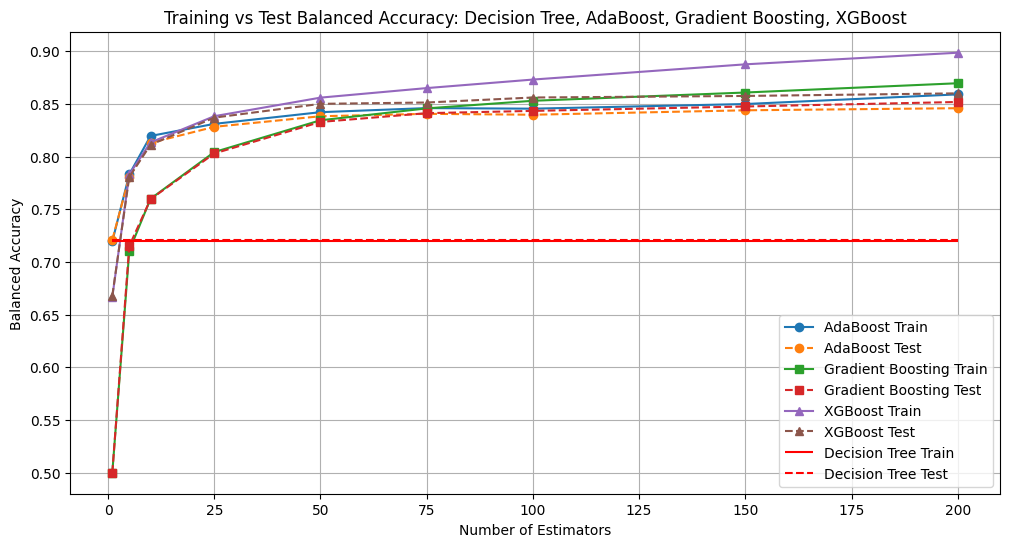

In [8]:


le = LabelEncoder()
y_encoded = le.fit_transform(y)  # 'g' -> 0, 'h' -> 1

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)
# ----- Parameters -----
n_estimators_list = [1, 5, 10, 25, 50, 75, 100, 150, 200]

# Storage
adaboost_bal_train = []
adaboost_bal_test = []
gb_bal_train = []
gb_bal_test = []
xgb_bal_train = []
xgb_bal_test = []

# Loop over different numbers of estimators
for n in n_estimators_list:
    # ----- AdaBoost -----
    adaboost_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', AdaBoostClassifier(
            estimator=DecisionTreeClassifier(max_depth=3),
            n_estimators=n,
            random_state=42
        ))
    ])
    adaboost_pipeline.fit(X_train, y_train)
    adaboost_bal_train.append(balanced_accuracy_score(y_train, adaboost_pipeline.predict(X_train)))
    adaboost_bal_test.append(balanced_accuracy_score(y_test, adaboost_pipeline.predict(X_test)))
    
    # ----- Gradient Boosting -----
    gb_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', GradientBoostingClassifier(
            n_estimators=n,
            max_depth=3,
            random_state=42
        ))
    ])
    gb_pipeline.fit(X_train, y_train)
    gb_bal_train.append(balanced_accuracy_score(y_train, gb_pipeline.predict(X_train)))
    gb_bal_test.append(balanced_accuracy_score(y_test, gb_pipeline.predict(X_test)))

    # ----- XGBoost -----
    xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        n_estimators=n,
        max_depth=3,
        eval_metric='logloss',  # keep this to avoid old warning
        random_state=42,
        n_jobs=-1
    ))
])
    xgb_pipeline.fit(X_train, y_train)
    xgb_bal_train.append(balanced_accuracy_score(y_train, xgb_pipeline.predict(X_train)))
    xgb_bal_test.append(balanced_accuracy_score(y_test, xgb_pipeline.predict(X_test)))

# ----- Single Decision Tree for reference -----
dt = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(max_depth=3, random_state=42))
])
dt.fit(X_train, y_train)
dt_bal_train = balanced_accuracy_score(y_train, dt.predict(X_train))
dt_bal_test = balanced_accuracy_score(y_test, dt.predict(X_test))

# ----- Plot -----
plt.figure(figsize=(12,6))
plt.plot(n_estimators_list, adaboost_bal_train, 'o-', label='AdaBoost Train')
plt.plot(n_estimators_list, adaboost_bal_test, 'o--', label='AdaBoost Test')
plt.plot(n_estimators_list, gb_bal_train, 's-', label='Gradient Boosting Train')
plt.plot(n_estimators_list, gb_bal_test, 's--', label='Gradient Boosting Test')
plt.plot(n_estimators_list, xgb_bal_train, '^-', label='XGBoost Train')
plt.plot(n_estimators_list, xgb_bal_test, '^--', label='XGBoost Test')
plt.hlines(dt_bal_train, n_estimators_list[0], n_estimators_list[-1], colors='red', linestyles='-', label='Decision Tree Train')
plt.hlines(dt_bal_test, n_estimators_list[0], n_estimators_list[-1], colors='red', linestyles='--', label='Decision Tree Test')
plt.xlabel('Number of Estimators')
plt.ylabel('Balanced Accuracy')
plt.title('Training vs Test Balanced Accuracy: Decision Tree, AdaBoost, Gradient Boosting, XGBoost')
plt.legend()
plt.grid(True)
plt.show()